# Final result
After iterations of testers, the best models were taken and improved upon further by hyperparameter tuning. <br>

Starting out with:
* Replace missing values with mean
* Robust scaler
* Recursive Feature Elimination
* Train Test Split
* Gradient Boosting Classification                                

In [94]:
# import necessary modules

import sys
sys.path.append('../scripts')

from open_file import open_file
import data_preprocessing
import model_training
import evaluation
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [95]:
# Classification task changed from [no cancer, benign, malignant] to [no cancer = 0, cancer = 1]
classify_diagnosis = data_preprocessing.classify_diagnosis

# original data (mostly)
df = open_file()

# converting diagnosis to boolean (ignore if commented out above)
df['diagnosis'] = df['diagnosis'].apply(classify_diagnosis)

# seperating X and y
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [96]:
X

,age,is_male,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,0,11.7,1.83222,0.893219,52.948840,654.282174,1262.000
1,81,0,NaN,0.97266,2.037585,94.467030,209.488250,228.407
2,51,1,7.0,0.78039,0.145589,102.366000,461.141000,NaN
3,61,1,8.0,0.70122,0.002805,60.579000,142.950000,NaN
4,62,1,9.0,0.21489,0.000860,65.540000,41.088000,NaN
...,...,...,...,...,...,...,...,...
585,68,1,NaN,0.52026,7.058209,156.241000,525.178000,NaN
586,71,0,NaN,0.85956,8.341207,16.915000,245.947000,NaN
587,63,1,NaN,1.36851,7.674707,289.701000,537.286000,NaN
588,75,0,NaN,1.33458,8.206777,205.930000,722.523000,NaN


In [97]:
X_imputed_df = data_preprocessing.mean_missing(X)

In [98]:
X_scaled = data_preprocessing.robust_scaler(X_imputed_df)
X_scaled_df = pd.DataFrame(X_scaled, columns = X_imputed_df.columns)

In [99]:
selected_features = data_preprocessing.rfe_feature(X_scaled_df, y, n_features_to_select = 6)
selected_features

Index(['plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A'], dtype='object')

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df[selected_features], y, test_size=0.2, random_state=42)

In [28]:
# Define hyperparameters for GBM
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  # Adjusted to valid options
    'subsample': [0.8, 0.9, 1.0],
    'loss': ['exponential', 'log_loss']  # Adjusted to valid options
}

# Initialize GBM classifier
gbm_model = GradientBoostingClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(gbm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')

# Use the best model from Grid Search
best_gbm_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_gbm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Best Parameters: {'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.9}
Best Score: 0.8770436730123181
Accuracy: 0.9152542372881356


In [114]:
# Adjust Hyperparameters to increase accuracy
param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.18],
    'max_depth': [3],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [None],
    'subsample': [0.9],
    'loss': ['exponential']
}

# Initialize GBM classifier
gbm_model = GradientBoostingClassifier(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(gbm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')

# Use the best model from Grid Search
best_gbm_model = grid_search.best_estimator_

# Make predictions on the test data
y_pred = best_gbm_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))
print(conf_matrix)

Best Parameters: {'learning_rate': 0.18, 'loss': 'exponential', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.9}
Best Score: 0.8494960806270997
Accuracy: 0.940677966101695
              precision    recall  f1-score   support

           0       0.95      0.96      0.96        80
           1       0.92      0.89      0.91        38

    accuracy                           0.94       118
   macro avg       0.93      0.93      0.93       118
weighted avg       0.94      0.94      0.94       118

[[77  3]
 [ 4 34]]


In [102]:
# Confusion matrix into percent by actual values
# Extracting values
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

TNR = TN / (TN + FP) * 100  # Specificity
FPR = FP / (TN + FP) * 100  # Fall-out
FNR = FN / (FN + TP) * 100  # Miss rate
TPR = TP / (FN + TP) * 100  # Sensitivity or Recall

# Print the rates in a matrix format
print("Confusion Matrix Rates:")
print("------------------------")
print(f"{'':<10}{'Predicted Negative':<25}{'Predicted Positive':<25}")
print(f"{'Actual Negative':<10} {TNR:<25.2f}{FPR:<25.2f}")
print(f"{'Actual Positive':<10} {FNR:<25.2f}{TPR:<25.2f}")
print("------------------------")

Confusion Matrix Rates:
------------------------
          Predicted Negative       Predicted Positive       
Actual Negative 96.25                    3.75                     
Actual Positive 10.53                    89.47                    
------------------------


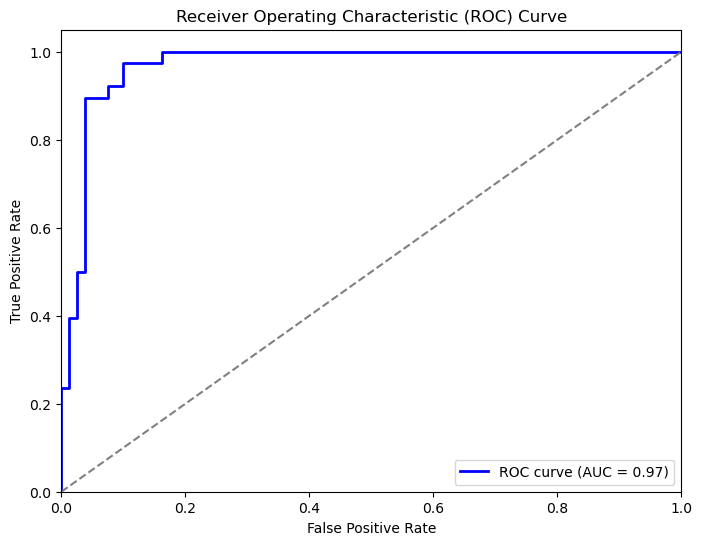

In [103]:
# ROC curve from the best fitting model
y_pred = best_gbm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Calculate the ROC curve and AUC
y_probs = best_gbm_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1
label_encoder = LabelEncoder()
y_test_numerical = label_encoder.fit_transform(y_test)

fpr, tpr, thresholds = roc_curve(y_test_numerical, y_probs)
roc_auc = auc(fpr, tpr)

# Print ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

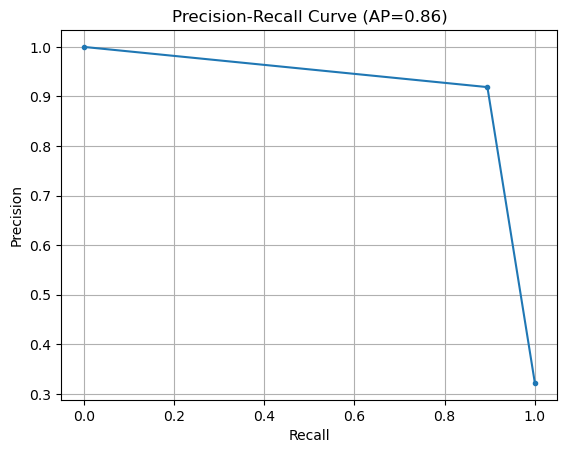

In [104]:
# precision- recall curve

# convert to numeric type
y_test_binary = y_test.astype(int)
y_pred_numeric = y_pred.astype(float)

precision, recall, thresholds = precision_recall_curve(y_test_binary, y_pred_numeric)
avg_precision = average_precision_score(y_test_binary, y_pred_numeric)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (AP={:.2f})'.format(avg_precision))
plt.grid(True)
plt.show()

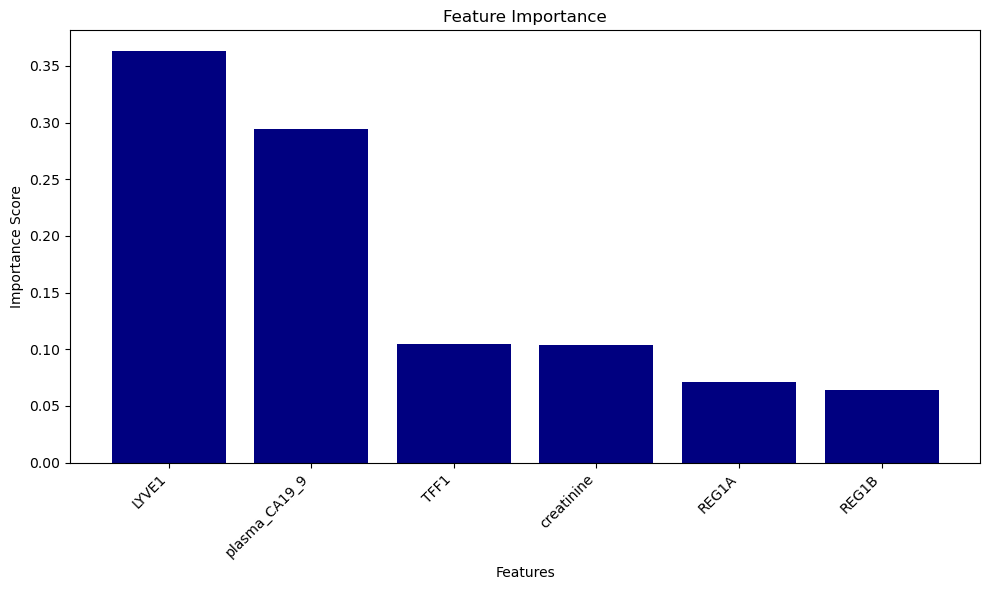

In [105]:
features = ['plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']
feature_importance = best_gbm_model.feature_importances_

feature_importance_combined = list(zip(features, feature_importance))

# Sort features by importance weight
feature_importance_combined.sort(key=lambda x: x[1], reverse=True)

# Unzip sorted features and importance scores
sorted_features, sorted_importance = zip(*feature_importance_combined)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_importance, color=(0, 0, 0.5))

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importance')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

# Results

After tuning hyperparameters the best model - giving a balance between TRUE POSITIVE RATE and TRUE NEGATIVE RATE was achieved. <br>

It had the following parameters:
* Missing Value Imputer: Mean
* Scaling / Normalization: Robust Scaling
* Feature Selection: Recursive Feature Elimination
* Data Splitting: Train Test Split
* Classification Model: Gradient Boosting Classification
    * Learning Rate: 0.18
    * Loss: exponential
    * Max_depth: 3
    * Max_features: None
    * Min_samples_lead: 1
    * Min_samples_split: 2
    * N_estimators: 50
    * Subsample: 0.9
    
With the following results:
* Accuracy: 94.1%
* Predicting 0 (no cancer)
    * Precision: 0.95
    * Recall: 0.96
    * F1 - score: 0.96
* Predicting 1 (cancer)
    * Precision: 0.92
    * Recall: 0.89
    * F1 - score: 0.91

For the given model, it was optimize to both account for FALSE POSITIVE RATE AND FALSE NEGATIVE RATE since both are harmful in their own way. <br>

The features most important to this model were LYVE1 and plasma_CA19_9 <br>

More conclusions can be found in the README.md